# 0. Google Colab Setups

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('./drive/MyDrive/NLP MedLM project')

In [ ]:
!pip install transformers

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.5 MB/s eta 0:00:00


In [ ]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 55.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 75.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=f245e7aed2bf2bcd5620ef99205ae36250fe0ad3407621d90e886430bce3338d
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 3.0 MB/s eta 0:00:00


# 1. Preprocessing combined dataset
+ Question and Anaswers needs to be combined to QA pairs for fine-tuning.
+ Only Question is needed for the testing data.
+ For training set data: Add [question] beofore each question text, and add[answer] before each answer text. For test set data: Add [question] before each question text and add [answer] to the end of the question.

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import torch
from transformers import BloomTokenizerFast, BloomForCausalLM, pipeline
from datasets import DatasetDict, Dataset
from transformers import Trainer, TrainingArguments
import evaluate

from tqdm import tqdm
import ast

In [ ]:
# load MedQuAD train and test dataset
train_df = pd.read_csv('./dataset/combined_train.csv')
test_df = pd.read_csv('./dataset/combined_test.csv')

In [ ]:
# add special tokens
# adding prompting tokens before each question and answer
def prepend_q(row):
  return '[question] ' + str(row)

def prepend_a(row):
  return '\n [answer] ' + str(row)

def prepend_qa(row):
  return '[question] ' + str(row) + '\n [answer]'

train_df['Question'] = train_df['Question'].apply(prepend_q)
train_df['Answer_cut'] = train_df['Answer_cut'].apply(prepend_a)
#combine question and answer
train_df['QA'] = train_df['Question'].str.cat(train_df['Answer_cut'], sep = '')

test_df['Question'] = test_df['Question'].apply(prepend_qa)

In [ ]:
# check data
train_df.head(1)

,Question,Answer,Answer_cut,QA
0,[question] can i get too many vitamins? if so ...,believe it or not you can actually take too ma...,\n [answer] believe it or not you can actually...,[question] can i get too many vitamins? if so ...


In [ ]:
test_df.head(1)

,Question,Answer,Answer_cut
0,[question] can rupturing a cyst under the skin...,this would be highly unlikely however i do not...,this would be highly unlikely however i do not...


In [ ]:
# split part of the data for evaluation
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=123)

In [ ]:
# form dataset with hf datasets
train = {
    "text" : train_df['QA']
}
test = {
    "text": val_df['QA']
}

train_dataset = Dataset.from_dict(train)
test_dataset = Dataset.from_dict(test)

datasets = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

# 2. Tokenization
+ Use tokenizer designed for BLOOM

In [ ]:
MODEL_TYPE = "bigscience/bloom-560m"
MAX_LENGTH = 300

tokenizer = BloomTokenizerFast.from_pretrained(MODEL_TYPE)
model = BloomForCausalLM.from_pretrained(MODEL_TYPE)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = model.to(device)
print(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

cuda:0


In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=MAX_LENGTH)

In [ ]:
# need to delete the original text column
tokenized_dataset = datasets.map(tokenize_function, batched=True, num_proc=8, remove_columns=["text"])

Map (num_proc=8):   0%|          | 0/29532 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/7384 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 29532
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 7384
    })
})

In [ ]:
block_size = MAX_LENGTH
def group_texts(examples):
  examples["labels"] = examples["input_ids"].copy()
  return examples

In [ ]:
lm_datasets = tokenized_dataset.map(
    group_texts,
    batched=True,
    batch_size=100,
    num_proc=8,
)

Map (num_proc=8):   0%|          | 0/29532 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/7384 [00:00<?, ? examples/s]

In [ ]:
lm_datasets['train'][0]

# 3. Fine-Tuning
+ From research, we learned that the learning rate during finetuning partly depends on the size of the dataset, when the dataset is small, it is better to use smaller learning rate.

In [ ]:
training_args = TrainingArguments(
    f"bloom-finetuned-combined",
    num_train_epochs= 1,
    per_device_train_batch_size= 2,
    gradient_checkpointing= True,
    gradient_accumulation_steps= 5,
    optim= "adafactor",
    logging_steps= 50,
    save_strategy= 'epoch',
    weight_decay= 0.1,
    learning_rate= 5e-6,
    evaluation_strategy= 'steps',
    eval_steps= 200,
    per_device_eval_batch_size= 2,
    warmup_ratio = 0.02 # epoch * 1%
)

trainer = Trainer(
    model= model,
    args= training_args,
    train_dataset= lm_datasets["train"],
    eval_dataset= lm_datasets["test"],
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differe

Step,Training Loss,Validation Loss
200,1.380100,1.402903
400,1.319100,1.356386
600,1.311300,1.332403
800,1.349200,1.313450
1000,1.349000,1.299450
1200,1.291100,1.289013
1400,1.227400,1.280059
1600,1.223000,1.271786
1800,1.291400,1.265001
2000,1.240500,1.259478


TrainOutput(global_step=2953, training_loss=1.4700818628607626, metrics={'train_runtime': 24468.5201, 'train_samples_per_second': 1.207, 'train_steps_per_second': 0.121, 'total_flos': 1.6069170290688e+16, 'train_loss': 1.4700818628607626, 'epoch': 1.0})

In [ ]:
train_log = pd.DataFrame(trainer.state.log_history)
train_log.to_csv("./bloom-finetuned-combined/train_log.csv", index = False)

<Axes: >

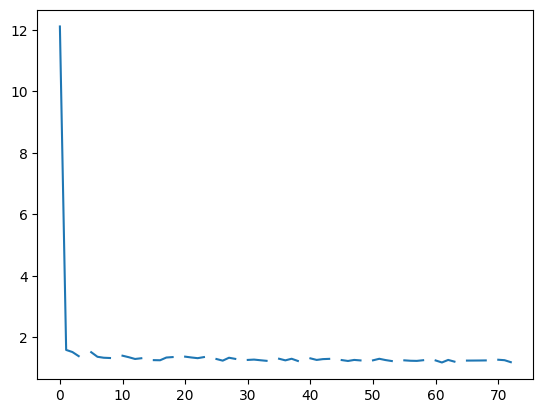

In [ ]:
# plot the training and validation loss
train_log['loss'].plot()

# 4. Inference
+ Use the finetuned model to perform inference on the test set

In [ ]:
tokenizer = BloomTokenizerFast.from_pretrained(MODEL_TYPE)
model = BloomForCausalLM.from_pretrained("./bloom-finetuned-combined/checkpoint-2953")
model.eval()

BloomForCausalLM(
  (transformer): BloomModel(
    (word_embeddings): Embedding(250880, 1024)
    (word_embeddings_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (h): ModuleList(
      (0-23): 24 x BloomBlock(
        (input_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (self_attention): BloomAttention(
          (query_key_value): Linear(in_features=1024, out_features=3072, bias=True)
          (dense): Linear(in_features=1024, out_features=1024, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (post_attention_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): BloomMLP(
          (dense_h_to_4h): Linear(in_features=1024, out_features=4096, bias=True)
          (gelu_impl): BloomGelu()
          (dense_4h_to_h): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = pipeline('text-generation', model=model.to(device), device = 0, tokenizer=tokenizer, do_sample=False)

In [ ]:
# test questions as list
test_data = test_df['Question'].tolist()

In [ ]:

# Divide the list into sublists
print(len(test_data))
sublists = [test_data[i:i+32] for i in range(0, len(test_data), 32)]
print(len(sublists))


9229
289


In [ ]:
# inference on all data
# test different batchsize to find the best suitable one
gen_ans_lists = []
for sub_test_data in tqdm(sublists):
  with torch.no_grad():
    gen_ans = generator(sub_test_data, max_new_tokens=300, batch_size=32 )
    gen_ans_lists.append(gen_ans)

In [ ]:
# store the temporary generated answers
len(gen_ans_lists)
gen_ans_df = pd.DataFrame(gen_ans_lists)
gen_ans_df.to_csv("combined_gen_ans.csv", index = False)

# 6. Evaluation
+ Use SacreBleu score and

In [ ]:
# load the generated answers
gen_ans_df = pd.read_csv("combined_gen_ans.csv")
gen_ans_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,[{'generated_text': '[question] can rupturing ...,[{'generated_text': '[question] what causes a ...,[{'generated_text': '[question] i have a great...,"[{'generated_text': ""[question] what are your ...",[{'generated_text': '[question] high blood pre...,[{'generated_text': '[question] What is (are) ...,[{'generated_text': '[question] What is the ou...,[{'generated_text': '[question] are immigrants...,[{'generated_text': '[question] What are the t...,[{'generated_text': '[question] can humira cau...,...,[{'generated_text': '[question] should i have ...,[{'generated_text': '[question] my frenulum to...,[{'generated_text': '[question] i began suffer...,[{'generated_text': '[question] what is the do...,[{'generated_text': '[question] how do you tre...,[{'generated_text': '[question] if you have a ...,"[{'generated_text': ""[question] pvc dildo not ...",[{'generated_text': '[question] should a physi...,[{'generated_text': '[question] i’m feeling di...,"[{'generated_text': ""[question] can vitamin c ..."
1,[{'generated_text': '[question] can a round ob...,[{'generated_text': '[question] when can a mam...,[{'generated_text': '[question] How many peopl...,"[{'generated_text': ""[question] i'm nicole i g...",[{'generated_text': '[question] What are the s...,[{'generated_text': '[question] my 5 year old ...,[{'generated_text': '[question] What are the s...,[{'generated_text': '[question] can a man be g...,[{'generated_text': '[question] what are examp...,[{'generated_text': '[question] Is L1 syndrome...,...,[{'generated_text': '[question] i had dengue f...,[{'generated_text': '[question] my finger was ...,[{'generated_text': '[question] my mom has sto...,[{'generated_text': '[question] How many peopl...,[{'generated_text': '[question] i’m embarrasse...,[{'generated_text': '[question] i am on ciprof...,[{'generated_text': '[question] can i use tyle...,[{'generated_text': '[question] vitamin b12 sh...,"[{'generated_text': ""[question] is bone struct...",[{'generated_text': '[question] is there somet...


In [ ]:
# extract the generated answers with sequence
gen_ans_list = []

for index, row in gen_ans_df.iterrows():
    for col in gen_ans_df.columns:
      try:
        ans = ast.literal_eval(row[col])[0]['generated_text']
        # only keep the answer part
        prompt = "\n [answer]"
        prompt_index = ans.find(prompt)
        if prompt_index != -1:
          extracted_ans = ans[prompt_index + len(prompt): ]
        else: # handle edge case
          extracted_ans = ans
      except:
        continue
      gen_ans_list.append(extracted_ans)


In [ ]:
# check the number of datapoints
print(len(test_df))
print(len(gen_ans_list))

# check a random sample's question and answer
print("question: ", test_df['Question'].iloc[2048])
print("generated_answer: ", gen_ans_list[2048])
print("reference_answer: ", test_df['Answer'].iloc[2048])

9229
9229
question:  [question] Is Fuchs endothelial corneal dystrophy inherited ?
 [answer]
generated_answer:   This condition is inherited in an autosomal recessive pattern, which means both copies of the gene in each cell have mutations. The parents of an individual with an autosomal recessive condition each carry one copy of the mutated gene, but they typically do not show signs and symptoms of the condition. The parents of an unaffected person with an autosomal recessive condition each have one copy of the mutated gene, but they typically do not show signs and symptoms of the condition. The parents of an unaffected person with an autosomal dominant condition each have one copy of the mutated gene, but they typically do not show signs and symptoms of the condition. The inheritance pattern of Fuchs endothelial corneal dystrophy is unknown. Most cases result from new mutations in the gene and occur in people with no history of the disorder in their family. The inheritance pattern of 

In [ ]:
"""
calculate SACREBLEU score
This part of the code is in reference to the official document provided by huggingface
https://huggingface.co/spaces/evaluate-metric/sacrebleu
"""
sacrebleu = evaluate.load("sacrebleu")

In [ ]:
# construct reference list
references = [[ref_ans] for ref_ans in test_df['Answer']]
predictions = gen_ans_list
sacrebleu_results = sacrebleu.compute(predictions=predictions, references=references)

In [ ]:
print(sacrebleu_results)

{'score': 4.324662567287595, 'counts': [318616, 106455, 69780, 58296], 'totals': [2519966, 2510737, 2501508, 2492279], 'precisions': [12.643662652591345, 4.239990090559067, 2.789517363126562, 2.339063965149969], 'bp': 1.0, 'sys_len': 2519966, 'ref_len': 1328123}


In [ ]:
"""
calculate the ROUGE score
This part of the code is in reference to the official document provided by huggingface
https://huggingface.co/spaces/evaluate-metric/rouge
"""
rouge = evaluate.load("rouge")

In [ ]:
rouge_results = rouge.compute(predictions=predictions, references=references)

In [ ]:
print(rouge_results)

{'rouge1': 0.13528450264593023, 'rouge2': 0.048976309951351285, 'rougeL': 0.11323779130536107, 'rougeLsum': 0.1131723137997602}
